Capital initial : 1 €
Capital final : 3165873.81 €
Retour sur investissement : 316587280.86 %


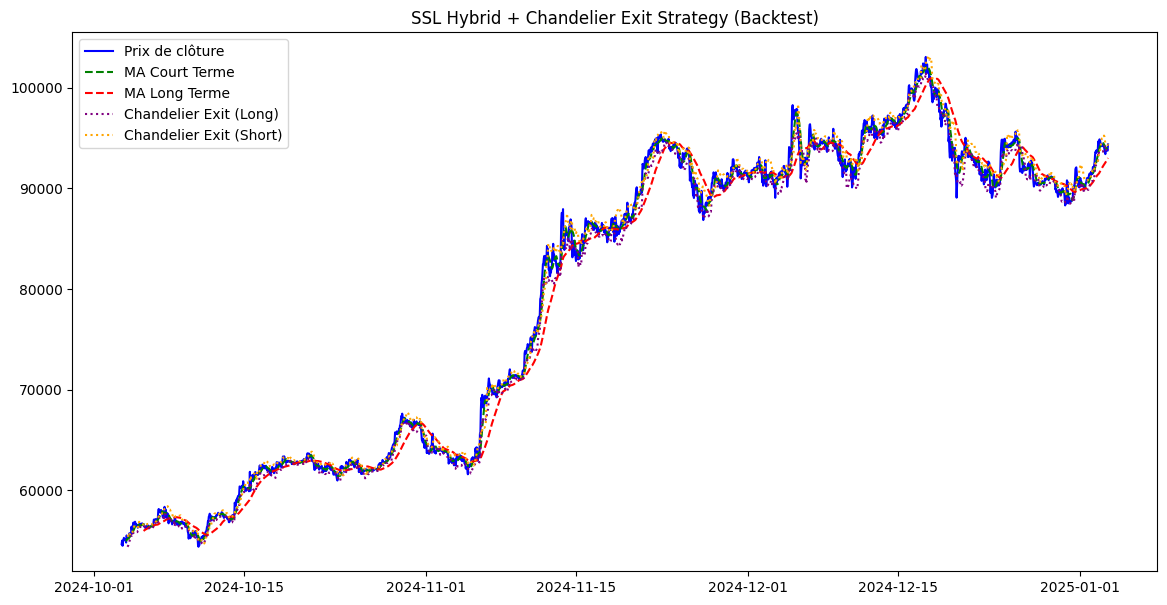

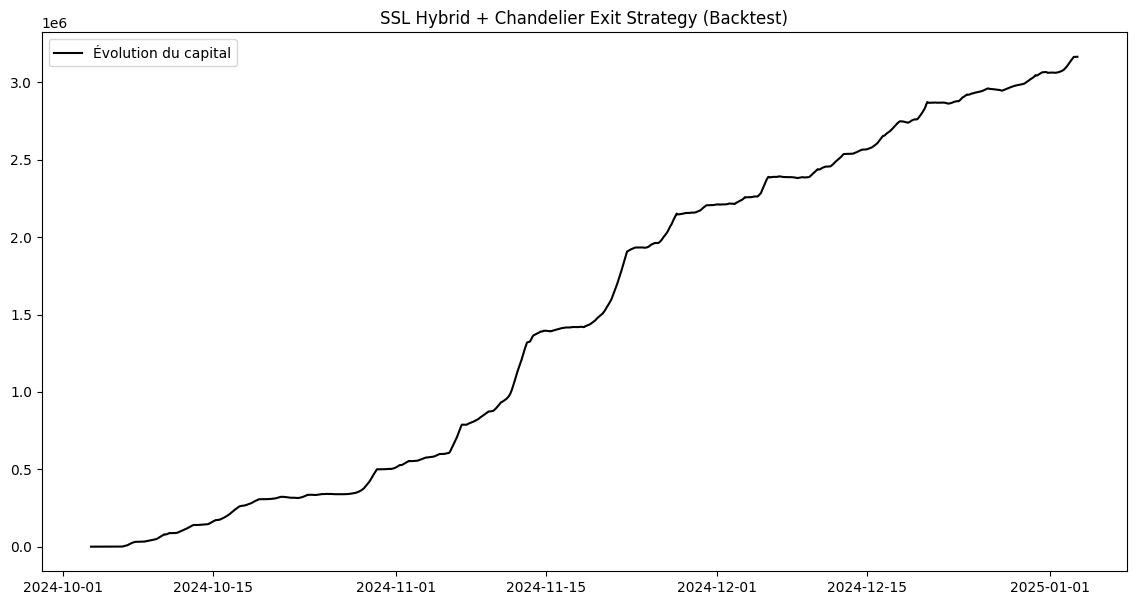

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2

# Fonction pour calculer les moyennes mobiles
def calculate_ma(data, period):
    return data.rolling(window=period).mean()

# Fonction pour calculer l'ATR
def calculate_atr(data, period):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift(1))
    low_close = np.abs(data['Low'] - data['Close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return true_range.rolling(window=period).mean()

# Fonction pour exécuter un backtest
def backtest(data, initial_capital=1, atr_multiplier=3):
    capital = initial_capital
    position = 0  # 1 pour long, -1 pour short, 0 pour aucune position
    entry_price = 0
    balance = []

    for i in range(len(data)):
        signal = data['Signal'].iloc[i]
        price = data['Close'].iloc[i]
        chandelier_long = data['Chandelier_Long'].iloc[i]
        chandelier_short = data['Chandelier_Short'].iloc[i]

        # Sortie de position
        if position == 1 and price < chandelier_long:  # Stop-loss long
            capital += position * (price - entry_price)
            position = 0
        elif position == -1 and price > chandelier_short:  # Stop-loss short
            capital += position * (entry_price - price)
            position = 0

        # Entrée en position
        if position == 0:
            if signal == 1:  # Achat
                position = 1
                entry_price = price
            elif signal == -1:  # Vente
                position = -1
                entry_price = price

        # Mettre à jour le capital en fonction de la position
        capital += position * (price - entry_price)
        balance.append(capital)

    data['Balance'] = balance
    return capital

# Charger les données
data = pd.read_csv('BTC-EUR_ticker.csv')  # Remplacez par le chemin de vos données
try:
    data['Date'] = pd.to_datetime(data['Date'])
except:
    data['Date'] = pd.to_datetime(data['Datetime'])
data.set_index('Date', inplace=True)

# Paramètres
short_ma_period = 10
long_ma_period = 50
atr_period = 14
atr_multiplier = 3
initial_capital = 1

# Calcul des indicateurs
data['Short_MA'] = calculate_ma(data['Close'], short_ma_period)
data['Long_MA'] = calculate_ma(data['Close'], long_ma_period)
data['ATR'] = calculate_atr(data, atr_period)

# Génération des signaux
data['Signal'] = 0
data.loc[data['Short_MA'] > data['Long_MA'], 'Signal'] = 1  # Achat
data.loc[data['Short_MA'] < data['Long_MA'], 'Signal'] = -1  # Vente

# Calcul du Chandelier Exit
data['Chandelier_Long'] = data['High'].rolling(window=atr_period).max() - (data['ATR'] * atr_multiplier)
data['Chandelier_Short'] = data['Low'].rolling(window=atr_period).min() + (data['ATR'] * atr_multiplier)

# Backtest
final_capital = backtest(data, initial_capital, atr_multiplier)

# Résultats
print(f"Capital initial : {initial_capital} €")
print(f"Capital final : {final_capital:.2f} €")
print(f"Retour sur investissement : {(final_capital - initial_capital) / initial_capital * 100:.2f} %")

# Visualisation
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Prix de clôture', color='blue')
plt.plot(data['Short_MA'], label='MA Court Terme', color='green', linestyle='--')
plt.plot(data['Long_MA'], label='MA Long Terme', color='red', linestyle='--')
plt.plot(data['Chandelier_Long'], label='Chandelier Exit (Long)', color='purple', linestyle=':')
plt.plot(data['Chandelier_Short'], label='Chandelier Exit (Short)', color='orange', linestyle=':')
plt.title('SSL Hybrid + Chandelier Exit Strategy (Backtest)')
plt.legend()
plt.show()

plt2.figure(figsize=(14, 7))
plt2.plot(data['Balance'], label='Évolution du capital', color='black')
plt2.title('SSL Hybrid + Chandelier Exit Strategy (Backtest)')
plt2.legend()
plt2.show()
